In [43]:
%load_ext autoreload
%autoreload 2

from Experiments import make_experiment
from plot_experiments import *
import yaml
import pandas as pd
from IPython.display import display

device = 'cmod'
#dataset_path = 'no_ufo_flattop_1452_shots_50%_disruptive'
#dataset_path = 'random_flattop_256_shots_60%_disruptive'
dataset_path = 'no_ufo_flattop_7736_shots_6%_disruptive'
stack_dataset_path = 'no_ufo_flattop_7736_shots_6%_disruptive/stack_4'

# Load models and create experiments

# models, alarms, metrics, and minimum warning times to use
models = ['dsm']
alarms = ['sthr', 'hyst']
metrics = ['auroc']
min_warning_times = [0.02]

# Create a list of experiments
experiment_list = []
for model in models:
    for alarm in alarms:
        for metric in metrics:
            for min_warning_time in min_warning_times:
                config_name = f'{model}_{alarm}_{metric}_{int(min_warning_time*1000)}ms'
                config_path = f'models/{device}/{dataset_path}/{config_name}.yaml'
                # Load yaml file into dictionary
                with open(config_path) as file:
                    config = yaml.load(file, Loader=yaml.FullLoader)

                # For each item in the config, replace it with the value
                for key in config:
                    if type(config[key]) == dict:
                        config[key] = config[key]['value']
                
                # Create test experiment from config
                experiment = make_experiment(config, 'test')
                experiment_list.append(experiment)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/dsm_sthr_auroc_20ms.pkl
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/dsm_hyst_auroc_20ms.pkl


## Micro Average ROC AUC vs Horizon

See how the models perform at the individual timeslice level across the entire database.

Two trends can be seen:
1. The survival models perform considerably better at longer horizons.
2. The survival models do not benefit as much as the binary classifiers from having temporal data of previous timeslices included in the feature list.

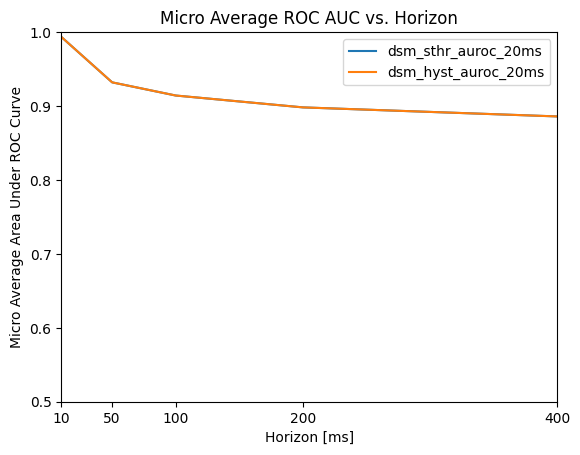

In [18]:
plot_roc_auc_vs_horizon_micro(experiment_list)

# 20ms and 100ms alarm performance.

## True Alarm Rate vs False Alarm Rate curve + enclosed area

## Warning Time vs False Alarm Rate curve

## At Best F1:
Avg + Std Warning Time:
True Alarm Rate:
False Alarm Rate:

In [44]:
required_warning_time = 0.02

result_data = []

#plot_TAR_vs_FAR(experiment_list, required_warning_time=required_warning_time)
#plot_warning_time_vs_FAR(experiment_list, required_warning_time=required_warning_time)

for experiment in experiment_list:
    auroc = experiment.au_true_alarm_rate_false_alarm_rate_curve(required_warning_time=required_warning_time)
    auwtc = experiment.au_warning_time_false_alarm_rate_curve(required_warning_time=required_warning_time)
    best_f1, tar, far, avg_warn, std_warn = experiment.max_f1(required_warning_time=required_warning_time, info=True)
    
    result_array = [experiment.name, auroc, auwtc*1000, best_f1, tar, far, avg_warn*1000, std_warn*1000]
    result_data.append(result_array)
    
result_df = pd.DataFrame(result_data, columns=['Name', 'AUROC', 'AUWTC', 'Max F1', 'TAR', 'FAR', 'Avg. Warn [ms]', 'Std. Warn [ms]'])
display(result_df)

,Name,AUROC,AUWTC,Max F1,TAR,FAR,Avg. Warn [ms],Std. Warn [ms]
0,dsm_sthr_auroc_20ms,0.492776,0.263794,0.507375,0.966292,1.0,[849.2134192937546],[225.45943484309785]
1,dsm_hyst_auroc_20ms,0.036408,0.000000,0.111940,0.168539,1.0,76.83987,153.921737


# One Model Type (several individual models)

Risk and ETTD plotted against what it should look like

In [46]:
#plot_disruptive_vs_non_disruptive_shot_durations(experiment_list[0])